In [1]:
import os
os.chdir('/home/mike/Desktop/Word Embeddings')
import pandas as pd
import pickle
from gensim.models import Word2Vec
from random import randint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

os.chdir('./Text Processing')
from TextPrep import TextPrep

os.chdir('../Meta Data')
from key_words import key_words, key_synonyms, base_words, base_synonyms, agree_words, agree_synonyms
from stop_words import stop_words
os.chdir('..')

In [2]:
def similar_words(word, model, topn):
    sim_words = []
    for i in range(topn):
        sim_words.append(model.wv.most_similar(word, topn = topn)[i][0])
    return sim_words + [word]

def similar_dict(words1, words2, labels):
    both = [word for word in words1 if word in words2]
    words1 = [word for word in words1 if word not in both]
    words2 = [word for word in words2 if word not in both]
    words = [words1, words2, both]
    labels = labels + ['Both']
    dictionary = {}
    for i in range(len(labels)):
        for word in words[i]:
            dictionary[word] = labels[i]
    return dictionary

def pca2df(pcamodel, embedding, dictionary):
    # convert the pca element to a df
    pc_df = pd.DataFrame(data = pcamodel, columns = ['pc1', 'pc2', 'pc3'])
    # add word column to the df
    pc_df['word'] = [key for key in embedding.wv.vocab]
    # get a list of unique words from the dictionary
    words = list(dictionary.keys())
    words = list(set(words))
    # keep only components that are in the list of unique words
    pc_df = pc_df[pc_df['word'].isin(words)].reset_index(drop=True)
    colors = {'Democrat': 'blue', 'Republican':'red', 'Both': 'purple', 'A': 'blue', 'B':'red'}
    pc_df['label'] = pc_df['word'].map(dictionary)
    pc_df['color'] = [colors[word] for word in pc_df['label']]
    return pc_df

In [3]:
# load in data
meta_data = pd.read_csv('Meta Data/meta_data.csv')
tweet_df = pd.read_csv('Replication/Data/replication_text.csv')

tweets = tweet_df['text']
labels = tweet_df['party']

# initialize parser
prep = TextPrep(stopwords = stop_words, key_words = key_words, key_synonyms = key_synonyms)

In [4]:
%%time
# preprocess text
tweets = [prep.twitter_preprocess(tweet) for tweet in tweets]

CPU times: user 1.21 s, sys: 2.52 ms, total: 1.21 s
Wall time: 1.22 s


# Impeach

### Impeach party labels

/home/mike/anaconda3/envs/embeddings/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


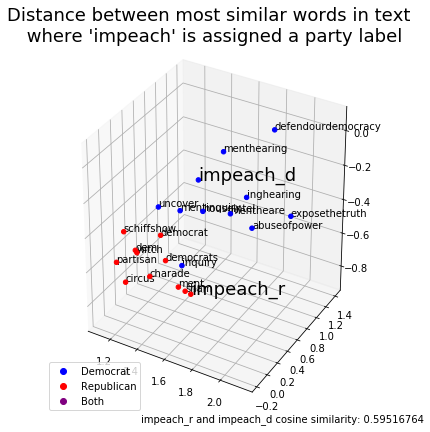

CPU times: user 1min 24s, sys: 2.74 s, total: 1min 27s
Wall time: 1min 8s


In [12]:
%%time
# tag keywords
pimpeach_tweets = []
for i in range(len(tweets)):
    try:
        pimpeach_tweets.append(prep.tag_keywords('impeach', tweets[i], labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
pimpeach_tweets = prep.multi_lemmatizer(pimpeach_tweets, threads = 6)

# drop single letters
for i in range(len(pimpeach_tweets)):
    pimpeach_tweets[i] = [word for word in pimpeach_tweets[i] if len(word) > 1]

# train word2vec
pimpeach_model = Word2Vec(pimpeach_tweets, window = 10, sg = 1)
pimpeach_model.save('Replication/impeach_party.model')
# assign data to variables
rimpeach_words = similar_words('impeach_r', pimpeach_model, topn = 10)
dimpeach_words = similar_words('impeach_d', pimpeach_model, topn = 10)
pimpeach_sim = pimpeach_model.wv.similarity('impeach_r', 'impeach_d')
pimpeach_dict = similar_dict(rimpeach_words, dimpeach_words, ['Republican', 'Democrat'])

# fit pca model
data = pimpeach_model[pimpeach_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, pimpeach_model, pimpeach_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

# define parameters
x = pcdf.pc1
y = pcdf.pc2
z = pcdf.pc3

# plot the points
scatter = ax.scatter(x, y, z, label=pcdf.label, color=pcdf.color, depthshade=False)

# label the points
for i in range(len(pcdf['word'])):
    label = pcdf.word[i]
    if label in ['impeach_r', 'impeach_d']:
        ax.text(x[i], y[i], z[i], s=label, size=18, zorder=1, color='k', horizontalalignment = 'left')
    else:
        ax.text(x[i], y[i], z[i], s=label, size=10, zorder=1, color='k', horizontalalignment = 'left')

# create legend
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='purple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['Democrat', 'Republican', 'Both'], numpoints = 1, loc = 3)

# title and subtext
plt.title('Distance between most similar words in text \n where \'impeach\' is assigned a party label', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'impeach_r and impeach_d cosine similarity: ' + str(pimpeach_sim), horizontalalignment='right')
plt.tight_layout()
plt.savefig('Replication/impeach_party.png')
plt.show()

### Impeach random labels

/home/mike/anaconda3/envs/embeddings/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


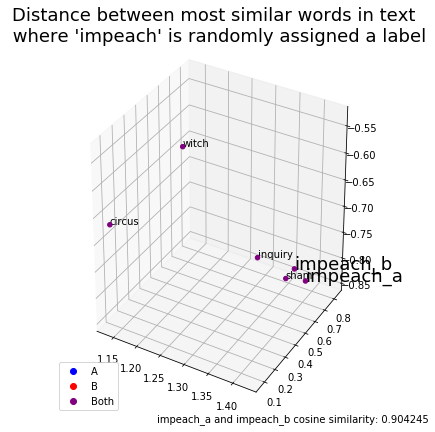

CPU times: user 1min 17s, sys: 2.18 s, total: 1min 19s
Wall time: 1min 1s


In [7]:
%%time
# generate random labels
rand_labels = [random.choice('ab') for label in labels]

# tag keywords
rimpeach_tweets = []
for i in range(len(tweets)):
    try:
        rimpeach_tweets.append(prep.tag_keywords('impeach', tweets[i], rand_labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
rimpeach_tweets = prep.multi_lemmatizer(rimpeach_tweets, threads = 6)

# drop single letters
for i in range(len(rimpeach_tweets)):
    rimpeach_tweets[i] = [word for word in rimpeach_tweets[i] if len(word) > 1]

# train word2vec
rimpeach_model = Word2Vec(rimpeach_tweets, window = 10, sg = 1)
rimpeach_model.save('Replication/impeach_random.model')
# assign data to variables
aimpeach_words = similar_words('impeach_a', rimpeach_model, topn = 5)
bimpeach_words = similar_words('impeach_b', rimpeach_model, topn = 5)
rimpeach_sim = rimpeach_model.wv.similarity('impeach_a', 'impeach_b')
rimpeach_dict = similar_dict(aimpeach_words, bimpeach_words, ['A', 'B'])

# fit pca model
data = rimpeach_model[rimpeach_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, rimpeach_model, rimpeach_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

# define parameters
x = pcdf.pc1
y = pcdf.pc2
z = pcdf.pc3

# plot the points
scatter = ax.scatter(x, y, z, label=pcdf.label, color=pcdf.color, depthshade=False)

# label the points
for i in range(len(pcdf['word'])):
    label = pcdf.word[i]
    if label in ['impeach_a', 'impeach_b']:
        ax.text(x[i], y[i], z[i], s=label, size=18, zorder=1, color='k', horizontalalignment = 'left')
    else:
        ax.text(x[i], y[i], z[i], s=label, size=10, zorder=1, color='k', horizontalalignment = 'left')

# create legend
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='purple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['A', 'B', 'Both'], numpoints = 1, loc = 3)

# title and subtext
plt.title('Distance between most similar words in text \n where \'impeach\' is randomly assigned a label', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'impeach_a and impeach_b cosine similarity: ' + str(rimpeach_sim), horizontalalignment='right')
plt.tight_layout()
plt.savefig('Replication/impeach_random.png')
plt.show()

## Look

/home/mike/anaconda3/envs/embeddings/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


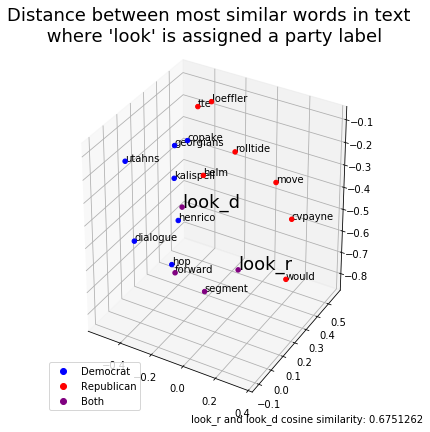

In [5]:
# initialize parser
prep = TextPrep(stopwords = stop_words, key_words = base_words, key_synonyms = base_synonyms)

# tag keywords
plook_tweets = []
for i in range(len(tweets)):
    try:
        plook_tweets.append(prep.tag_keywords('look', tweets[i], labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
plook_tweets = prep.multi_lemmatizer(plook_tweets, threads = 6)

# drop single letters
for i in range(len(plook_tweets)):
    plook_tweets[i] = [word for word in plook_tweets[i] if len(word) > 1]

# train word2vec
plook_model = Word2Vec(plook_tweets, window = 10, sg = 1)
plook_model.save('Replication/look_party.model')
# assign data to variables
rlook_words = similar_words('look_r', plook_model, topn = 10)
dlook_words = similar_words('look_d', plook_model, topn = 10)
plook_sim = plook_model.wv.similarity('look_r', 'look_d')
plook_dict = similar_dict(rlook_words, dlook_words, ['Republican', 'Democrat'])

# fit pca model
data = plook_model[plook_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, plook_model, plook_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

# define parameters
x = pcdf.pc1
y = pcdf.pc2
z = pcdf.pc3

# plot the points
scatter = ax.scatter(x, y, z, label=pcdf.label, color=pcdf.color, depthshade=False)

# label the points
for i in range(len(pcdf['word'])):
    label = pcdf.word[i]
    if label in ['look_r', 'look_d']:
        ax.text(x[i], y[i], z[i], s=label, size=18, zorder=1, color='k', horizontalalignment = 'left')
    else:
        ax.text(x[i], y[i], z[i], s=label, size=10, zorder=1, color='k', horizontalalignment = 'left')

# create legend
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='purple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['Democrat', 'Republican', 'Both'], numpoints = 1, loc = 3)

# title and subtext
plt.title('Distance between most similar words in text \n where \'look\' is assigned a party label', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'look_r and look_d cosine similarity: ' + str(plook_sim), horizontalalignment='right')
plt.tight_layout()
plt.savefig('Replication/look_party.png')
plt.show()

In [8]:
similar_words('look_r', plook_model, topn = 10)

['forward',
 'look_d',
 'tte',
 'move',
 'loeffler',
 'segment',
 'rolltide',
 'would',
 'cvpayne',
 'helm',
 'look_r']

In [9]:
similar_words('look_d', plook_model, topn = 10)

['look_r',
 'forward',
 'dialogue',
 'georgians',
 'copake',
 'henrico',
 'kalispell',
 'utahns',
 'segment',
 'hop',
 'look_d']

## Robocall

/home/mike/anaconda3/envs/embeddings/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


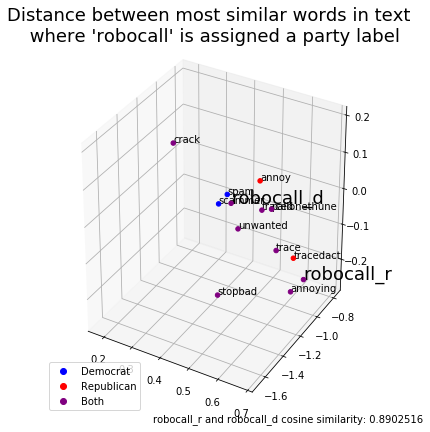

In [13]:
# initialize parser
prep = TextPrep(stopwords = stop_words, key_words = agree_words, key_synonyms = agree_synonyms)

# tag keywords
probocall_tweets = []
for i in range(len(tweets)):
    try:
        probocall_tweets.append(prep.tag_keywords('robocall', tweets[i], labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
probocall_tweets = prep.multi_lemmatizer(probocall_tweets, threads = 6)

# drop single letters
for i in range(len(probocall_tweets)):
    probocall_tweets[i] = [word for word in probocall_tweets[i] if len(word) > 1]

# train word2vec
probocall_model = Word2Vec(probocall_tweets, window = 10, sg = 1)
probocall_model.save('Replication/robocall_party.model')
# assign data to variables
rrobocall_words = similar_words('robocall_r', probocall_model, topn = 10)
drobocall_words = similar_words('robocall_d', probocall_model, topn = 10)
probocall_sim = probocall_model.wv.similarity('robocall_r', 'robocall_d')
probocall_dict = similar_dict(rrobocall_words, drobocall_words, ['Republican', 'Democrat'])

# fit pca model
data = probocall_model[probocall_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, probocall_model, probocall_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

# define parameters
x = pcdf.pc1
y = pcdf.pc2
z = pcdf.pc3

# plot the points
scatter = ax.scatter(x, y, z, label=pcdf.label, color=pcdf.color, depthshade=False)

# label the points
for i in range(len(pcdf['word'])):
    label = pcdf.word[i]
    if label in ['robocall_r', 'robocall_d']:
        ax.text(x[i], y[i], z[i], s=label, size=18, zorder=1, color='k', horizontalalignment = 'left')
    else:
        ax.text(x[i], y[i], z[i], s=label, size=10, zorder=1, color='k', horizontalalignment = 'left')

# create legend
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='purple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['Democrat', 'Republican', 'Both'], numpoints = 1, loc = 3)

# title and subtext
plt.title('Distance between most similar words in text \n where \'robocall\' is assigned a party label', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'robocall_r and robocall_d cosine similarity: ' + str(probocall_sim), horizontalalignment='right')
plt.tight_layout()
plt.savefig('Replication/robocall_party.png')
plt.show()

# convert top words to DF

In [18]:
# impeach
impeachr_df = pd.DataFrame(pimpeach_model.wv.most_similar('impeach_r', topn = 10), columns = ['word2', 'cosine sim'])
impeachr_df['word1'] = 'impeach_r'

impeachd_df = pd.DataFrame(pimpeach_model.wv.most_similar('impeach_d', topn = 10), columns = ['word2', 'cosine sim'])
impeachd_df['word1'] = 'impeach_d'

# robocall
robocallr_df = pd.DataFrame(probocall_model.wv.most_similar('robocall_r', topn = 10), columns = ['word2', 'cosine sim'])
robocallr_df['word1'] = 'robocall_r'

robocalld_df = pd.DataFrame(probocall_model.wv.most_similar('robocall_d', topn = 10), columns = ['word2', 'cosine sim'])
robocalld_df['word1'] = 'robocall_d'

# look
lookr_df = pd.DataFrame(plook_model.wv.most_similar('look_r', topn = 10), columns = ['word2', 'cosine sim'])
lookr_df['word1'] = 'look_r'

lookd_df = pd.DataFrame(plook_model.wv.most_similar('look_d', topn = 10), columns = ['word2', 'cosine sim'])
lookd_df['word1'] = 'look_d'

# combine
similar_words = pd.concat([impeachr_df, impeachd_df, robocallr_df, robocalld_df, lookr_df, lookd_df]).reset_index(drop=True)
similar_words.to_csv('hypothesis1_similar_words.csv', index=False)

## Development

## function for looping through all words

In [9]:
%%time
# variables needed: keyword, list of tweets, list of labels, tagged keywords
# unsure if I want most similar words or not
# adjust number of threads, add variable to toggle multithreading

# 
def cosine_sim(keyword, text, labels):
    # define tagged keywords. To generalize get a list of unique labels. loop through create a new variable for each label
    keyword_r = keyword + '_r'
    keyword_d = keyword + '_d'
    
    ptweets = []
    for i in range(len(text)):
        try:
            ptweets.append(prep.tag_keywords(keyword, text[i], labels[i])) # tweets and labels are global variables. change to local
        except:
            print('failed at '+ str(i))

    # lemmatize
    ptweets = prep.multi_lemmatizer(ptweets, threads = 6)

    # drop single letters
    for i in range(len(ptweets)):
        ptweets[i] = [word for word in ptweets[i] if len(word) > 1]

    # train and save word2vec
    pmodel = Word2Vec(ptweets, window = 10, sg = 1)

    # assign data to variables
    #rwords = similar_words(keyword_r, ptrump_model, topn = 5)
    #dwords = similar_words(keyword_d, ptrump_model, topn = 5)
    psim = pmodel.wv.similarity(keyword_r, keyword_d)
    #pdict = similar_dict(rtrump_words, dtrump_words, ['Republican', 'Democrat'])
    return psim

CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 29.3 µs


In [10]:
%%time
trump_sim = cosine_sim('trump', text = tweets, labels = labels)

CPU times: user 2min 28s, sys: 7.45 s, total: 2min 36s
Wall time: 53.9 s
